In [449]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization,Input, Flatten,  Conv1D, MaxPooling1D
from keras.layers import Dropout
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.ops import math_ops
from keras.optimizers import Adam
import keras
import tensorflow
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
import pandas as pd 
from sklearn.preprocessing import LabelEncoder 
import pandas_ta as ta
import tensorflow.experimental.numpy as tnp
import scipy.stats as stats
from nixtlats import TimeGPT
import graphviz, pydot

           Effective date  \
0     2014-02-28 00:00:00   
1     2014-03-03 00:00:00   
2     2014-03-04 00:00:00   
3     2014-03-05 00:00:00   
4     2014-03-06 00:00:00   
...                   ...   
2590  2024-02-27 00:00:00   
2591  2024-02-28 00:00:00   
2592  2024-02-29 00:00:00   
2593  2024-03-01 00:00:00   
2594  2024-03-04 00:00:00   

      Dow Jones Sukuk Total Return Index (ex-Reinvestment)  
0                                                146.75     
1                                                146.76     
2                                                146.79     
3                                                146.63     
4                                                146.49     
...                                                 ...     
2590                                             196.57     
2591                                             196.60     
2592                                             196.76     
2593                                     

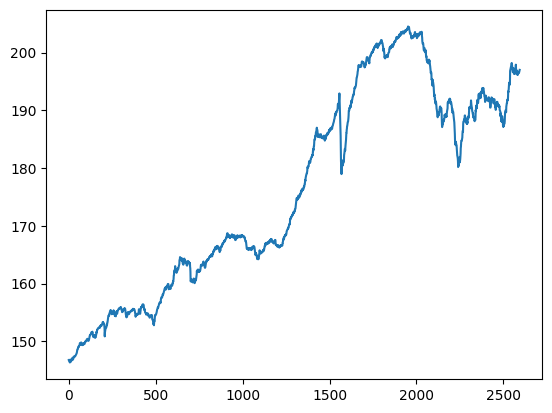

In [464]:
# Load data
folder_path = "CSV files/"
name = "Dow Jones Sukuk Total Return Index (ex-Reinvestment)"
data = pd.read_csv(folder_path + "Dow Jones Sukuk Index (ex-Reinvestment).csv")
print(data) 
# Extract features (date) and target (price)v
X = data["Effective date"]
y = data[name]
pyplot.plot(data[name], label='Effective date')
pyplot.show()

In [465]:
# Adding indicators
data['RSI']=ta.rsi(data[name], length=15)
data['EMAF']=ta.ema(data[name], length=15)
data['EMAM']=ta.ema(data[name], length=90)
data['EMAS']=ta.ema(data[name], length=150)
data['Price_diff'] = data[name].diff()
data['EMAF_diff'] = data['EMAF'].diff()
data['Next_Price_diff'] = data[name].diff().shift(-1)
data['Next_EMAF_diff'] = data['EMAF'].diff().shift(-1)
data['Next_Price'] = data[name].shift(-1)
#data['Target'] = data['Adj Close']-data.Open
#data['Target'] = data['Target'].shift(-1)
#data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]
#data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data

,index,Effective date,Dow Jones Sukuk Total Return Index (ex-Reinvestment),RSI,EMAF,EMAM,EMAS,Price_diff,EMAF_diff,Next_Price_diff,Next_EMAF_diff,Next_Price
0,149,2014-09-25 00:00:00,151.05,52.108521,151.041550,150.112508,149.134000,-0.01,0.001207,-0.24,-0.028944,150.81
1,150,2014-09-26 00:00:00,150.81,44.210882,151.012606,150.127838,149.156199,-0.24,-0.028944,-0.21,-0.051576,150.60
2,151,2014-09-29 00:00:00,150.60,38.710548,150.961030,150.138215,149.175322,-0.21,-0.051576,0.00,-0.045129,150.60
3,152,2014-09-30 00:00:00,150.60,38.710548,150.915902,150.148364,149.194192,0.00,-0.045129,0.06,-0.031988,150.66
4,153,2014-10-01 00:00:00,150.66,41.113441,150.883914,150.159609,149.213606,0.06,-0.031988,0.08,-0.017989,150.74
...,...,...,...,...,...,...,...,...,...,...,...,...
2440,2589,2024-02-26 00:00:00,196.68,53.167626,196.522203,194.937286,193.801298,0.21,0.022542,-0.11,0.005975,196.57
2441,2590,2024-02-27 00:00:00,196.57,51.186552,196.528177,194.973170,193.837969,-0.11,0.005975,0.03,0.008978,196.60
2442,2591,2024-02-28 00:00:00,196.60,51.712305,196.537155,195.008924,193.874552,0.03,0.008978,0.16,0.027856,196.76
2443,2592,2024-02-29 00:00:00,196.76,54.511941,196.565011,195.047409,193.912770,0.16,0.027856,0.23,0.053124,196.99


In [466]:
print((data["Next_Price_diff"] > 0).sum())
print((data["Next_Price_diff"] < 0).sum())
print((data["Next_Price_diff"] == 0).sum())

positive = 0
negative = 0
nul = 0

for x in data["Next_Price_diff"]:
    if x > 0:
        positive += x
    elif x < 0:
        negative += x
    else:
        nul += x
print(positive)
print(negative)
print(nul)

print(positive + negative)
print(data[name][len(data)-1] - data[name][0])
data["Next_Price_diff"].describe()


1346
1034
65
227.4300000000003
-181.4700000000003
0.0
45.95999999999998
45.94


count    2445.000000
mean        0.018798
std         0.249503
min        -2.470000
25%        -0.090000
50%         0.020000
75%         0.140000
max         1.970000
Name: Next_Price_diff, dtype: float64

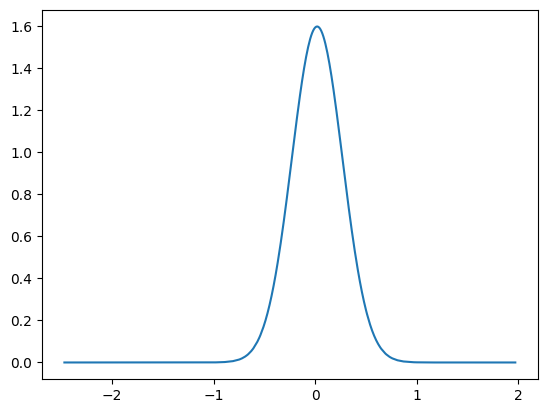

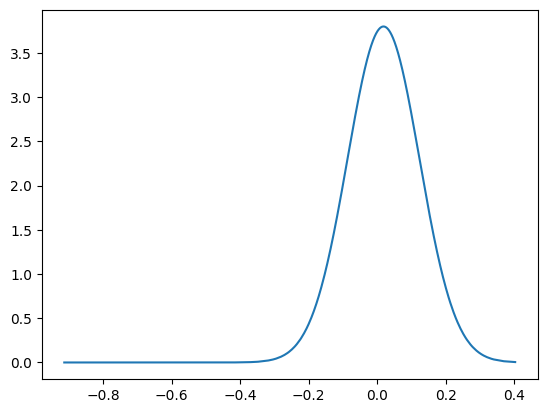

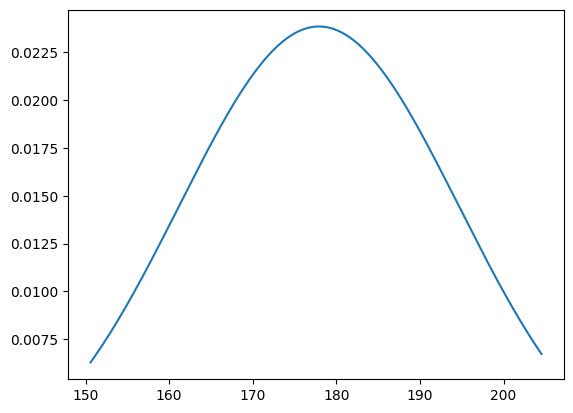

In [467]:
pdf = stats.norm.pdf(data['Next_Price_diff'].sort_values(), np.mean(data["Next_Price_diff"]), np.std(data["Next_Price_diff"]))
plt.plot(data['Next_Price_diff'].sort_values(), pdf)
plt.show()
pdf = stats.norm.pdf(data['Next_EMAF_diff'].sort_values(), np.mean(data['Next_EMAF_diff']), np.std(data['Next_EMAF_diff']))
plt.plot(data['Next_EMAF_diff'].sort_values(), pdf)
plt.show()
pdf = stats.norm.pdf(data['Next_Price'].sort_values(), np.mean(data['Next_Price']), np.std(data['Next_Price']))
plt.plot(data['Next_Price'].sort_values(), pdf)
plt.show()

In [6]:
timegpt = TimeGPT(
    # defaults to os.environ.get("TIMEGPT_TOKEN")
    token = 'eQgqY23AnClxUtounMajMKRrIxjRJcM5NeJYEsQdXCD30xJuj7RKEGdYngsTOae8fA7fEj37waf8Fm3zY8YHbLDwdkS2V1SVAmlMyHWjgguzGEs5nM75q0wnYo0YZHr5xAJmHPkpt6cDJTrgto6072DbKSFiPaSCobAmGPRUjGlt1mFXKxSIbusk4ZpO3ze794KrG95zhRZ72QFuaY3zvhnwclbo9Ll5DAHk38eR1dnaig03pOtMPsAOjkjNkisS'

)
timegpt.validate_token()

INFO:nixtlats.timegpt:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

In [7]:
df = pd.read_csv('xx.csv')
df[0:200]

,Effective date,S&P Global High Yield Sukuk Index
0,2014-02-28 00:00:00,102.12
1,2014-03-03 00:00:00,102.41
2,2014-03-04 00:00:00,102.12
3,2014-03-05 00:00:00,102.17
4,2014-03-06 00:00:00,102.08
...,...,...
195,2014-11-28 00:00:00,109.51
196,2014-12-01 00:00:00,109.50
197,2014-12-02 00:00:00,109.43
198,2014-12-03 00:00:00,109.46


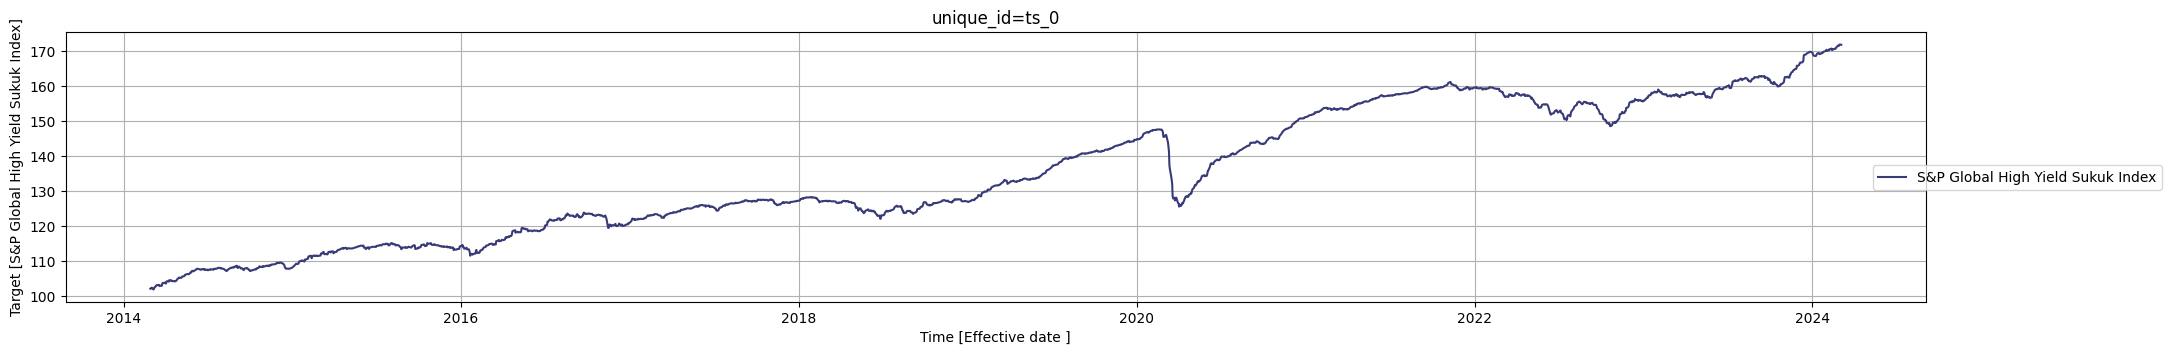

In [8]:
#df['Effective date'] = pd.to_datetime(df['Effective date'], format='%Y-%m-%d %H:%M:%S')
timegpt.plot(df, time_col='Effective date ', target_col=name)

In [9]:
timegpt_fcst_df = timegpt.forecast(df=df[0:-200], h=12, freq='MS', time_col='Effective date ', target_col=name)
timegpt_fcst_df.head()

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


,Effective date,TimeGPT
0,2023-06-01,158.059341
1,2023-07-01,158.103745
2,2023-08-01,158.414841
3,2023-09-01,159.033279
4,2023-10-01,158.429916


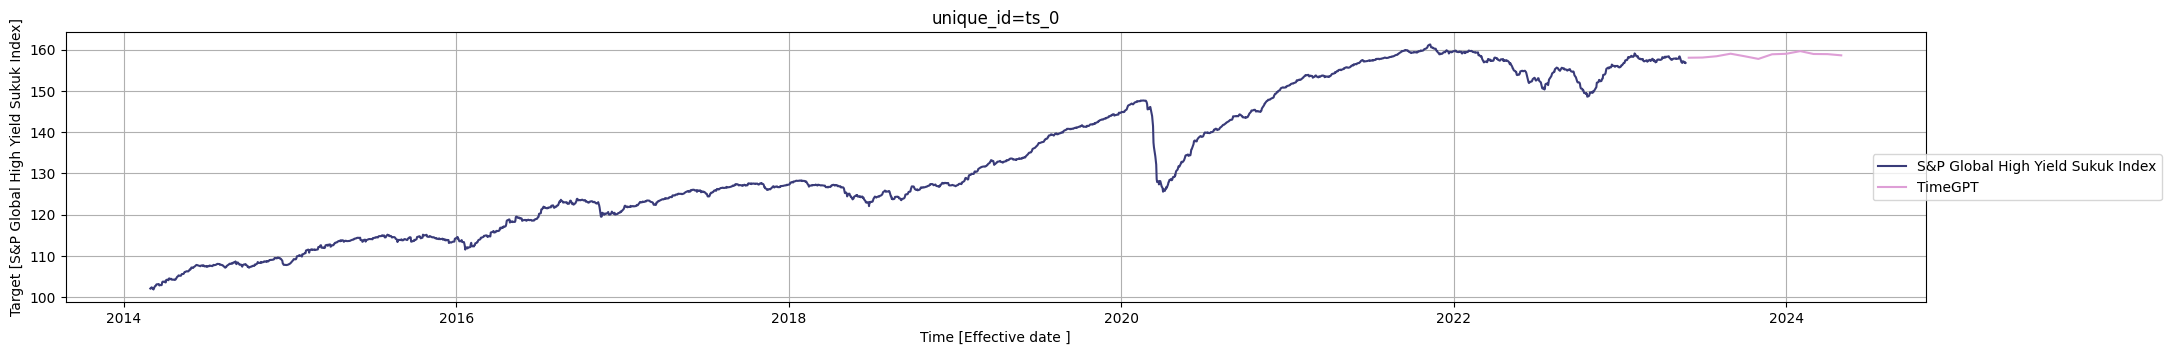

In [10]:
timegpt.plot(df[0:-200], timegpt_fcst_df, time_col='Effective date ', target_col='S&P Global High Yield Sukuk Index')

[[ 1.5105e+02 -1.0000e-02  1.5081e+02]
 [ 1.5081e+02 -2.4000e-01  1.5060e+02]
 [ 1.5060e+02 -2.1000e-01  1.5060e+02]
 ...
 [ 1.9660e+02  3.0000e-02  1.9676e+02]
 [ 1.9676e+02  1.6000e-01  1.9699e+02]
 [ 1.9699e+02  2.3000e-01  1.9701e+02]]


TypeError: unhashable type: 'numpy.ndarray'

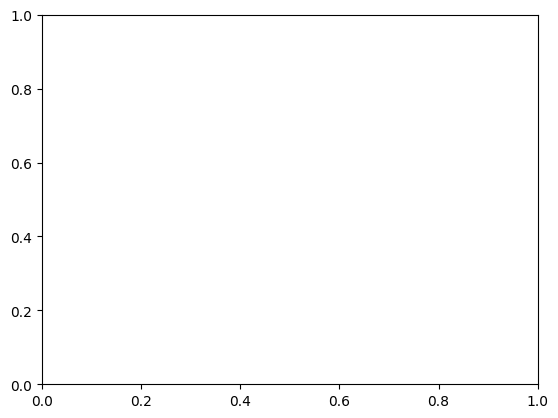

In [469]:
data_set_values = data.iloc[:, np.r_[2,7,11]].values
print(data_set_values)
#r_[2:4,4,5:9,11]
data.iloc[:, np.r_[2,7,11]]
#data_set_values.shape
pyplot.plot(data.iloc[0:50, 1:2], label='Effective date')
pyplot.show()
pyplot.plot(data["Next_Price_diff"], label='Effective date')
pyplot.show()


In [470]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set_values)
data_set_values = data_set_scaled
print(data_set_values.shape)

(2445, 3)


In [471]:
# multiple feature from data provided to the model
X = []
Y = []
#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
backcandles = 30
n_forecast = 10
print(data_set_values.shape[0])
for j in range(data_set_values.shape[1] - 1):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_values.shape[0] - n_forecast + 1):#backcandles+2
        X[j].append(data_set_values[i-backcandles:i, j])
  
       
       
Y.append([])
for i in range(backcandles, data_set_values.shape[0] - n_forecast + 1):
    Y[0].append(data_set_values[i: i + n_forecast, -1])


#move axis from 0 to position 2
X= np.moveaxis(X, [0], [2])
Y= np.moveaxis(Y, [0], [2])
#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X =np.array(X)
Y = np.array(Y)
#X = X.reshape(X.shape[0], backcandles)
Y = Y.reshape(Y.shape[0], n_forecast)
y = Y
#yi = np.array(data_set_values[backcandles:,-1])
#y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(y)
print(X.shape)
print(y.shape)


2445
[[[0.00834415 0.55405405]
  [0.00389394 0.50225225]
  [0.         0.50900901]
  ...
  [0.03356202 0.57882883]
  [0.03430373 0.56531532]
  [0.03319117 0.54279279]]

 [[0.00389394 0.50225225]
  [0.         0.50900901]
  [0.         0.55630631]
  ...
  [0.03430373 0.56531532]
  [0.03319117 0.54279279]
  [0.03319117 0.55630631]]

 [[0.         0.50900901]
  [0.         0.55630631]
  [0.00111255 0.56981982]
  ...
  [0.03319117 0.54279279]
  [0.03319117 0.55630631]
  [0.03282032 0.5518018 ]]

 ...

 [[0.86334137 0.51576577]
  [0.85889116 0.50225225]
  [0.85481179 0.50675676]
  ...
  [0.85481179 0.56981982]
  [0.84591137 0.4481982 ]
  [0.84461339 0.54054054]]

 [[0.85889116 0.50225225]
  [0.85481179 0.50675676]
  [0.85277211 0.53153153]
  ...
  [0.84591137 0.4481982 ]
  [0.84461339 0.54054054]
  [0.84961988 0.61711712]]

 [[0.85481179 0.50675676]
  [0.85277211 0.53153153]
  [0.8555535  0.59009009]
  ...
  [0.84461339 0.54054054]
  [0.84961988 0.61711712]
  [0.84516966 0.50225225]]]
[[0.0

In [472]:


# Preprocess date data (consider converting to numerical format)
# This example uses string representation for simplicity
#X = pd.to_datetime(X)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
y_test.shape
#X_test.shape
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


(482, 10)

In [458]:
#model = Sequential()

#model.add(Dense(256, activation="relu", input_dim=7))
#model.add(BatchNormalization())
#model.add(Dropout(0.01))
act = "linear"
drop = 0.01



inputLayer = Input(shape=(X_train.shape[1], X_train.shape[2]))
#hidden1_lstm = LSTM(units=16,  return_sequences=False)(inputLayer)
hidden1_lstm = Flatten()(inputLayer)
#hidden2_lstm = LSTM(32, return_sequences=False,  dropout= drop)(hidden1_lstm)
#hidden1_lstm =  Conv1D(filters=64, kernel_size=10, activation=act, input_shape = (X_train.shape[1], X_train.shape[2]))(inputLayer)
#hidden2_lstm = Flatten()(hidden1_lstm)
#hidden1_lstm = MaxPooling1D(pool_size=4)(hidden1_lstm)

#hidden2_lstm = Flatten()(hidden1_lstm)
hidden2_lstm = Dense(1024, activation=act)(hidden1_lstm)

hidden3_dense = Dense(512, activation=act)(hidden2_lstm)
hidden4_dense = Dense(256, activation=act)(hidden3_dense)
for i in range(2):
   hidden4_dense = Dense(128, activation=act)(hidden4_dense)

out_dense = []
for i in range(y.shape[1]):
   out_dense.append(Dense(1, activation="linear")(hidden4_dense))

out_dense = keras.layers.concatenate(out_dense)
#out_dense = Dense(y.shape[1], activation="linear")(hidden3_dense)
model = keras.Model(inputs = inputLayer, outputs = out_dense)



#model.add(LSTM(units=64,  return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

#model.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Flatten())
# model.add(Dense(units=128))
# model.add(Dense(units=64 ))

#model.add(LSTM(64, return_sequences=False,  dropout= drop))

# model.add(Flatten())
# model.add(Dense(1024, activation=act))
# model.add(Dropout(drop))
# model.add(Dense(512, activation=act))

#model.add(Dense(32, activation=act))

# Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
# Typically ReLu-based activation are used but since it is performed regression, it is needed a linear activation.

#model.add(Dense(y.shape[1], activation="linear"))



lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
tnp.experimental_enable_numpy_behavior(
    prefer_float32=False, dtype_conversion_mode='legacy'
)
@tensorflow.function(autograph=True)
def custom_loss(y_true, y_pred):
 
 diff =  math_ops.squared_difference(y_pred, y_true)  #squared difference
 diff_temp = tnp.array([])
 for i in range(len(diff)):
    tensorflow.autograph.experimental.set_loop_options(
                shape_invariants=[(diff_temp, tensorflow.TensorShape([None]))]
            )
    coef = 1
    X = tnp.array([])
    for j in range(len(diff[i])):
       X = tnp.append(X, diff[i][j] * coef ) 
       coef+=1
    diff_temp = tnp.append(diff_temp, X)
 #print(diff)
 #loss = math_ops.reduce_mean(diff)
 #print(loss)   
    #print("finish")
 loss = keras.backend.mean(diff_temp) #mean over last dimension
 loss = loss 
 return loss


#'mean_squared_error'
# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mean_squared_error', optimizer= Adam(learning_rate=lr_schedule), run_eagerly=False)

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
model.summary()
# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=X.shape[0], verbose=1, callbacks=[es])

# Calculate predictions
PredTestSet = model.predict(X_train)
PredValSet = model.predict(X_test)

# Save predictions
#np.savetxt("trainresults.csv", PredTestSet, delimiter=",")
#np.savetxt("valresults.csv", PredValSet, delimiter=",")
model.summary()

Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_46 (InputLayer)       [(None, 30, 2)]              0         []                            
                                                                                                  
 flatten_29 (Flatten)        (None, 60)                   0         ['input_46[0][0]']            
                                                                                                  
 dense_670 (Dense)           (None, 1024)                 62464     ['flatten_29[0][0]']          
                                                                                                  
 dense_671 (Dense)           (None, 512)                  524800    ['dense_670[0][0]']           
                                                                                           

In [430]:
keras.utils.plot_model(model, show_shapes= True, show_layer_activations=True)
print(np.asarray(model.predict(X_test)).shape)

16/16 [==============================] - 0s 3ms/step
(482, 10)


In [481]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=X.shape[0], verbose=1, callbacks=[es])

Epoch 1/200
1/1 [==============================] - 0s 149ms/step - loss: 2.3464e-04 - val_loss: 4.9137e-04
Epoch 2/200
1/1 [==============================] - 0s 66ms/step - loss: 2.3457e-04 - val_loss: 4.9123e-04
Epoch 3/200
1/1 [==============================] - 0s 83ms/step - loss: 2.3450e-04 - val_loss: 4.9109e-04
Epoch 4/200
1/1 [==============================] - 0s 78ms/step - loss: 2.3444e-04 - val_loss: 4.9095e-04
Epoch 5/200
1/1 [==============================] - 0s 211ms/step - loss: 2.3437e-04 - val_loss: 4.9081e-04
Epoch 6/200
1/1 [==============================] - 0s 109ms/step - loss: 2.3430e-04 - val_loss: 4.9067e-04
Epoch 7/200
1/1 [==============================] - 0s 111ms/step - loss: 2.3424e-04 - val_loss: 4.9054e-04
Epoch 8/200
1/1 [==============================] - 0s 94ms/step - loss: 2.3417e-04 - val_loss: 4.9040e-04
Epoch 9/200
1/1 [==============================] - 0s 67ms/step - loss: 2.3411e-04 - val_loss: 4.9027e-04
Epoch 10/200
1/1 [========================

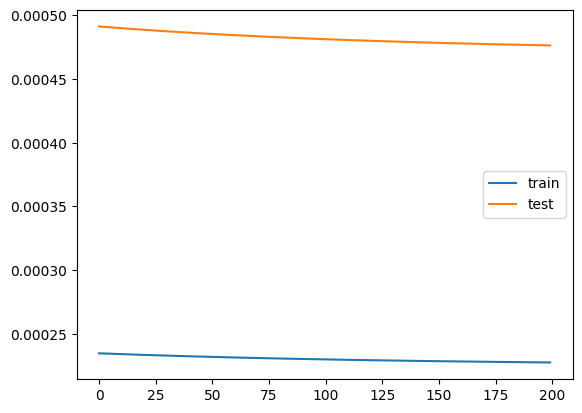

In [482]:

# Plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [483]:
#unscaled_data = sc.inverse_transform(scaled_data)
y_pred = model.predict(X_test) # * sc.data_min_[7] + (sc.data_max_[7] - sc.data_min_[7])
y_pred = np.array(y_pred).reshape((-1,y.shape[1]))
#X = np.array(y_pred).reshape((-1,y.shape[1]))
#y_pred = X
#print(X.shape)
y_test_inversed =  y_test * sc.data_min_[-1] + (sc.data_max_[-1] - sc.data_min_[-1])
#print(np.array(y_test_inversed).shape)

y_pred = y_pred  * sc.data_min_[-1] + (sc.data_max_[-1] - sc.data_min_[-1])
#y_pred=np.where(y_pred > 0.43, 1,0)

for i in range(10):
    print(y_pred[-i], y_test_inversed[-i])
   

print(np.asarray(y_pred).shape)
print(np.asarray(y_test_inversed).shape)
   

16/16 [==============================] - 0s 4ms/step
[170.30432 170.9274  169.81906 169.11194 168.78098 167.43079 167.17616
 167.0281  167.28401 169.15659] [170.74064343 170.71271834 169.17683849 169.65156499 168.53456147
 168.59041164 167.22208233 168.08776006 168.0039848  167.752659  ]
[182.04309 180.79565 182.19482 180.91544 181.19559 180.51297 182.79138
 181.01733 181.24484 180.91132] [182.02237901 181.99445392 181.82690339 182.02237901 182.60880586
 182.30162989 182.38540515 182.83220656 183.47448359 183.53033377]
[181.79659 181.45882 182.15686 182.82675 182.358   182.99515 183.082
 183.10849 182.76218 181.78952] [181.49180234 182.02237901 181.99445392 181.82690339 182.02237901
 182.60880586 182.30162989 182.38540515 182.83220656 183.47448359]
[180.4515  181.09648 180.63824 181.28012 180.79616 180.5278  179.73727
 180.39056 180.33728 180.60788] [181.21255146 181.49180234 182.02237901 181.99445392 181.82690339
 182.02237901 182.60880586 182.30162989 182.38540515 182.83220656]
[180.

In [484]:
y_predd = [[164.46146, 157.44827, 175.57133],
[164.47305, 157.4592, 175.58517],
[164.25914, 157.26147, 175.33142],
[164.09756, 157.11252, 175.1396 ]]

y_truee = [[170.37956803, 170.79294354, 171.47087936],
[170.31342795, 170.37956803, 170.79294354],
[169.88351743, 170.31342795, 170.37956803],
[169.91658747, 169.88351743, 170.31342795]]

@tensorflow.function(autograph=True)
def custom_loss(y_true, y_pred):
 #diff =  math_ops.squared_difference(y_pred, y_true)  #squared difference
 #print(diff)
 trueList = tnp.array([])
 predList = tnp.array([])
 for i in range(len(y_pred)):
    coef = 1
    X = tnp.array([])
    for j in range(len(y_pred[i])):
       X = tnp.append(X, y_pred[i][j] * coef ) 
       coef+=1
    predList = tnp.append(predList, X)
 print(y_pred)
 print(predList)
 for i in range(len(y_true)):
    coef = 1
    X = tnp.array([])
    for j in range(len(y_true[i])):
       X = tnp.append(X, y_true[i][j] * coef ) 
       coef+=1
    trueList = tnp.append(trueList, X)
       #print(j)
    #print(coef)
    #print(diff[i])
 #print(diff)
 print(type(trueList))
 #trueList = tensorflow.TensorArray(dtype= list, size= 0, dynamic_size=True)
 #predList = tensorflow.TensorArray(dtype= list, size= 0, dynamic_size=True)
 trueList = tnp.reshape(trueList, (-1, 3))
 predList = tnp.reshape(predList, (-1, 3))
 print(y_true)
 print(trueList)
 diff =  math_ops.squared_difference(y_pred, y_true)  #squared difference
 diff_temp = tnp.array([])
 for i in range(len(diff)):
    tensorflow.autograph.experimental.set_loop_options(
                shape_invariants=[(predList, tensorflow.TensorShape([None]))]
            )
    coef = 1
    X = tnp.array([])
    for j in range(len(diff[i])):
       X = tnp.append(X, diff[i][j] * coef ) 
       coef+=1
    diff_temp = tnp.append(diff_temp, X)
 print("gi")
 print(diff_temp)
 #loss = math_ops.reduce_mean(diff)
 #print(loss)   
    #print("finish")
 loss = keras.backend.mean(diff_temp) #mean over last dimension
 loss = loss 
 return loss

print(custom_loss(y_true=y_truee, y_pred=y_predd))

[[164.46146, 157.44827, 175.57133], [164.47305, 157.4592, 175.58517], [164.25914, 157.26147, 175.33142], [164.09756, 157.11252, 175.1396]]
Tensor("concat_15:0", shape=(12,), dtype=float64)
<class 'tensorflow.python.framework.ops.SymbolicTensor'>
[[170.37956803, 170.79294354, 171.47087936], [170.31342795, 170.37956803, 170.79294354], [169.88351743, 170.31342795, 170.37956803], [169.91658747, 169.88351743, 170.31342795]]
Tensor("Reshape_64:0", shape=(4, 3), dtype=float64)
gi
Tensor("concat_47:0", shape=(12,), dtype=float64)
tf.Tensor(146.19502449035645, shape=(), dtype=float64)


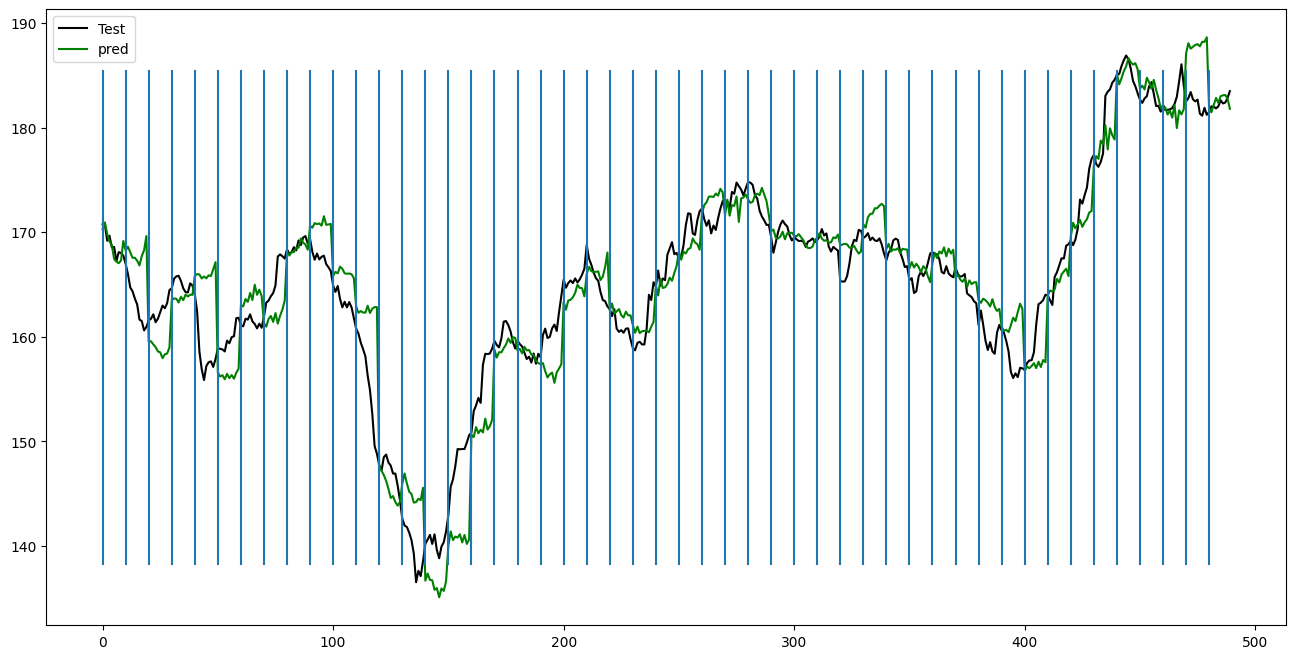

[170 135 135 135 135 135 135 135 135 135 170 135 135 135 135 135 135 135
 135 135 170 135 135 135 135 135 135 135 135 135 170 135 135 135 135 135
 135 135 135 135 170 135 135 135 135 135 135 135 135 135 170 135 135 135
 135 135 135 135 135 135 170 135 135 135 135 135 135 135 135 135 170 135
 135 135 135 135 135 135 135 135 170 135 135 135 135 135 135 135 135 135
 170 135 135 135 135 135 135 135 135 135 170 135 135 135 135 135 135 135
 135 135 170 135 135 135 135 135 135 135 135 135 170 135 135 135 135 135
 135 135 135 135 170 135 135 135 135 135 135 135 135 135 170 135 135 135
 135 135 135 135 135 135 170 135 135 135 135 135 135 135 135 135 170 135
 135 135 135 135 135 135 135 135 170 135 135 135 135 135 135 135 135 135
 170 135 135 135 135 135 135 135 135 135 170 135 135 135 135 135 135 135
 135 135 170 135 135 135 135 135 135 135 135 135 170 135 135 135 135 135
 135 135 135 135 170 135 135 135 135 135 135 135 135 135 170 135 135 135
 135 135 135 135 135 135 170 135 135 135 135 135 13

(49, 10)

In [485]:
plt.figure(figsize=(16,8))
Y_test_inversed = []
Y_pred = []
splits = []


for i in range(0,int(0.2 * len(X)),n_forecast):
    Y_test_inversed.append(y_test_inversed[i])
    Y_pred.append(y_pred[i])
    splits.append(170)
    for _ in range(n_forecast-1):
        splits.append(135)

plt.plot( np.array(Y_test_inversed).reshape(-1), color = 'black', label = 'Test')
plt.plot(np.array(Y_pred).reshape(-1), color = 'green', label = 'pred')
for xc in range(0,int(0.2 * len(X)),n_forecast):
    plt.axvline(x=xc , ymax=0.9, ymin=0.1)
plt.legend()
plt.show()
print(np.array(splits).reshape(-1))
Y_test_inversed = np.array(Y_test_inversed)
Y_test_inversed.reshape(-1)
Y_test_inversed.shape

61/61 [==============================] - 0s 2ms/step


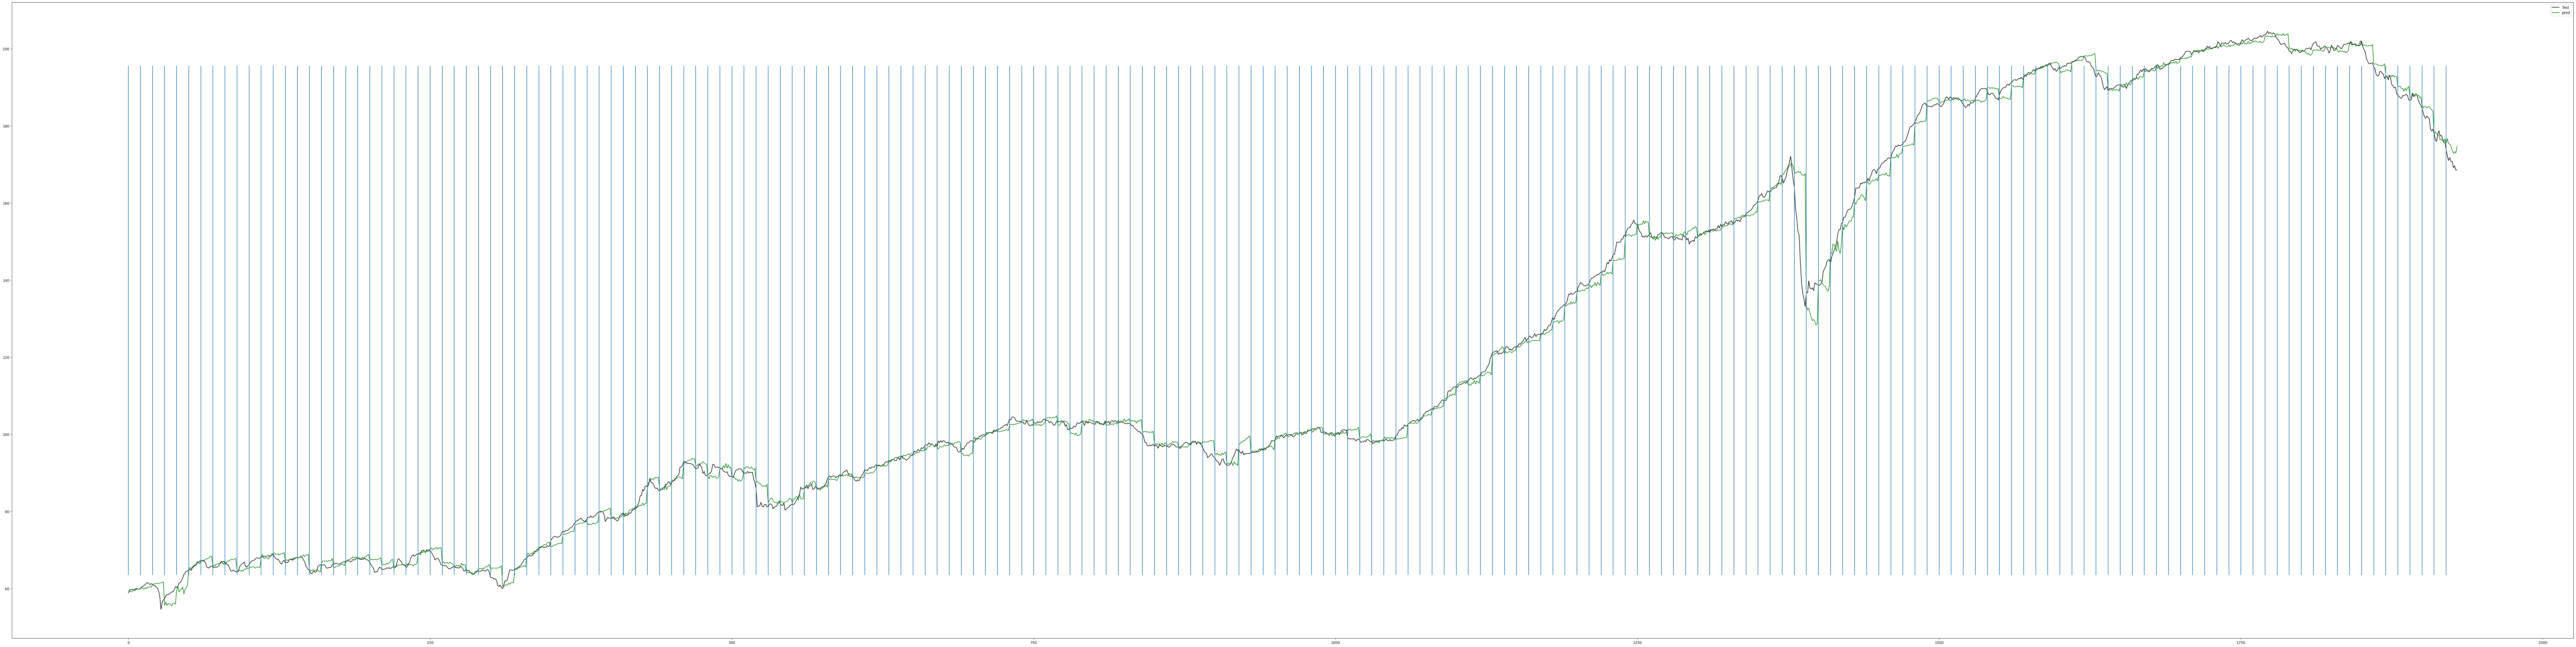

[170 135 135 ... 135 135 135]


(193, 10)

In [486]:
y_pred = model.predict(X_train) # * sc.data_min_[7] + (sc.data_max_[7] - sc.data_min_[7])
y_pred = np.array(y_pred).reshape((-1,y.shape[1]))
#X = np.array(y_pred).reshape((-1,y.shape[1]))
#y_pred = X
#print(X.shape)
y_train_inversed =  y_train * sc.data_min_[-1] + (sc.data_max_[-1] - sc.data_min_[-1])
#print(np.array(y_test_inversed).shape)

y_pred = y_pred  * sc.data_min_[-1] + (sc.data_max_[-1] - sc.data_min_[-1])

plt.figure(figsize=(128,32))
Y_train_inversed = []
Y_pred = []
splits = []


for i in range(0,int(0.8 * len(X)),n_forecast):
    Y_train_inversed.append(y_train_inversed[i])
    Y_pred.append(y_pred[i])
    splits.append(170)
    for _ in range(n_forecast-1):
        splits.append(135)

plt.plot( np.array(Y_train_inversed).reshape(-1), color = 'black', label = 'Test')
plt.plot(np.array(Y_pred).reshape(-1), color = 'green', label = 'pred')
for xc in range(0,int(0.8 * len(X)),n_forecast):
    plt.axvline(x=xc , ymax=0.9, ymin=0.1)
plt.legend()
plt.show()
print(np.array(splits).reshape(-1))
Y_train_inversed = np.array(Y_train_inversed)
Y_train_inversed.reshape(-1)
Y_train_inversed.shape

C:\Users\friha\AppData\Local\Temp\ipykernel_18896\1223803026.py:2: UserWarning: genfromtxt: Empty input file: "trainresults.csv"
  TestResults = np.genfromtxt("trainresults.csv", delimiter=",")


ValueError: x and y must have same first dimension, but have shapes (1926, 10) and (0,)

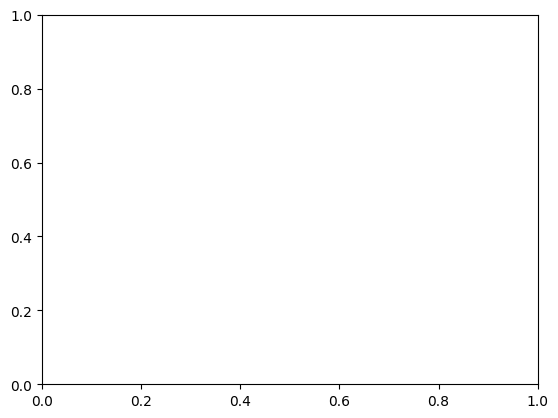

In [12]:

# Plot actual vs prediction for training set
TestResults = np.genfromtxt("trainresults.csv", delimiter=",")
plt.plot(y_train,TestResults,'ro')
plt.title('Training Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Compute R-Square value for training set
TestR2Value = r2_score(y_train,TestResults)
print("Training Set R-Square=", TestR2Value)

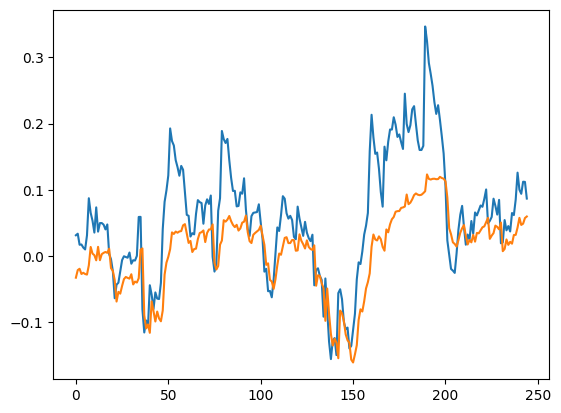

In [ ]:
pyplot.show()
val = []
for i in range(len(data_set) - train_size):
    val.append(y_test[train_size + i])
TestvalResults = numpy.genfromtxt("valresults.csv", delimiter=",")
#pyplot.plot(model.predict(data_set.iloc[0:90, 2:9]), label='Effective date')
pyplot.plot(val, label='Effective date')
pyplot.plot(TestvalResults, label='Effective date')


pyplot.show()